# Project 1 – Decision Trees and Random Forests

In [95]:
# Reload all modules without having to restart the kernel
# Useful for development if you have edited any of the external code files.
%load_ext autoreload
%autoreload 2

# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# My implementations
from decision_tree import DecisionTree
from random_forest import RandomForest

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

Do data loading, exploration and preprocessing as you see fit.

Here is some code to load the dataset to get you started.

In [96]:
data = np.genfromtxt("wine_dataset_small.csv", delimiter=",", dtype=float, names=True)

feature_names = list(data.dtype.names[:-1])
target_name = data.dtype.names[-1]

X = np.array([data[feature] for feature in feature_names]).T
y = data[target_name].astype(int)

print(f"Feature columns names: {feature_names}")
print(f"Target column name: {target_name}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Feature columns names: ['citric_acid', 'residual_sugar', 'pH', 'sulphates', 'alcohol']
Target column name: type
X shape: (500, 5)
y shape: (500,)


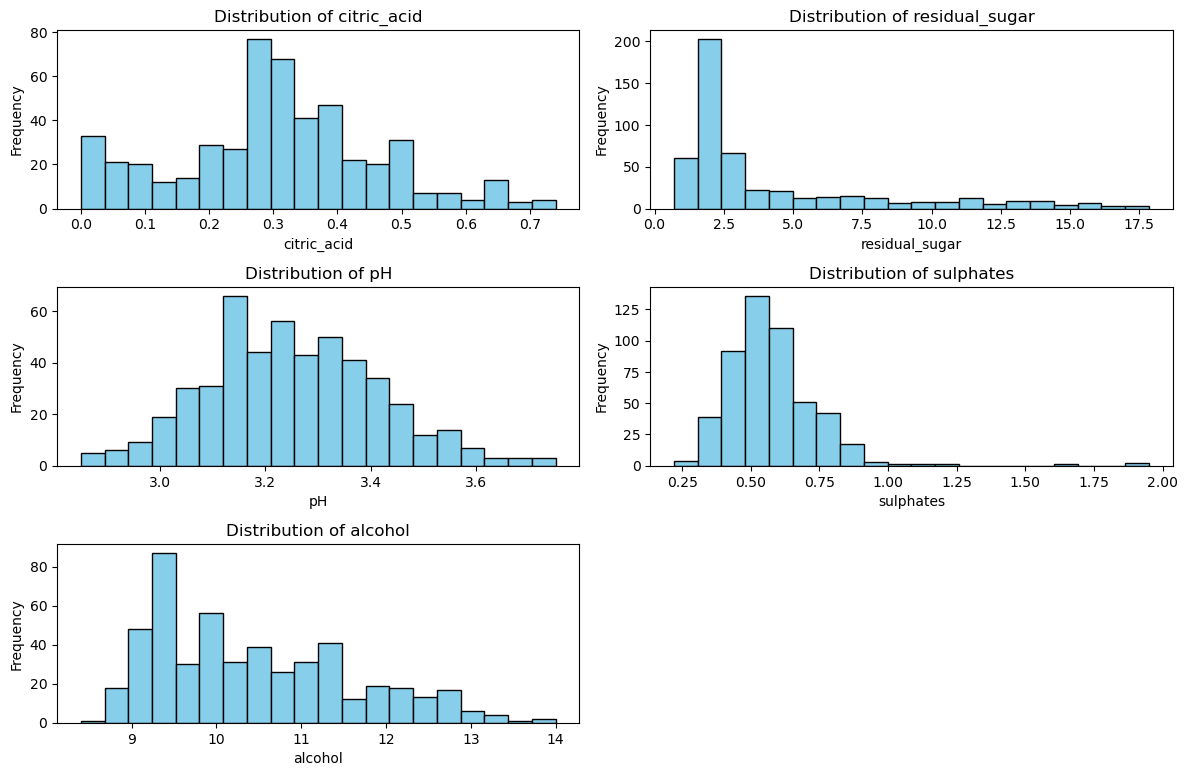

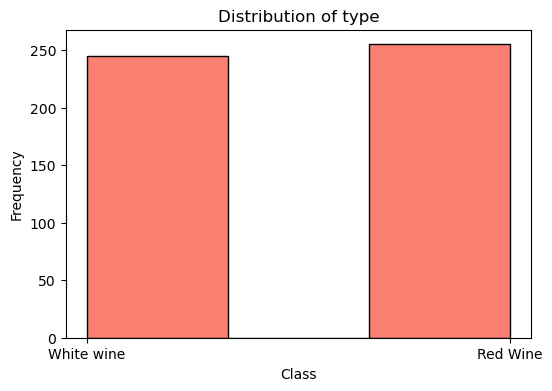

In [97]:
# Display the wine data
plt.figure(figsize=(12, 10))
for i, feature in enumerate(feature_names):
    plt.subplot(4, 2, i+1) 
    plt.hist(X[:, i], bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 4))
plt.hist(y, bins=3, color='salmon', edgecolor='black')
plt.title(f"Distribution of {target_name}")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks([0, 1], ["White wine", "Red Wine"])
plt.show()

In [98]:
# Set seed 
seed = 0

np.random.seed(seed)


#Split the data into test and (training and validation)

X_train_val, X_test, y_train_val, y_test = train_test_split(X,y, test_size=0.3, random_state=seed, shuffle=True)

# Use k fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

In [99]:
# Lists of hyperparameters that i want to tune

# Decision tree:
decision_tree_max_depth_params = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,None]

# Random forest:
max_depth_params = [3,5,7,9,11,13,15,17,19,21,None]

n_estimators = [2,5,7,10,15,20]

criterion = ["gini", "entropy"]

max_features = ["sqrt", "log2", None]




# Use this if running the code takes too long time:

decision_tree_max_depth_params = [3,10,15,20,None]

max_depth_params = [5,10,None]

n_estimators = [2,10,15]

criterion = ["gini", "entropy"]

max_features = ["sqrt", "log2", None]


In [100]:
# Function for tuning random forest using k-fold cross validation

def tune_random_forest(model_type, X_train_val, y_train_val, n_estimators, max_depth_params, criterion, max_features, kf):
    best_accuracy = [0]  # To store the best average accuracy and the corresponding hyperparameters
    
    # Iterate through all combinations of hyperparameters
    for maxdp in max_depth_params:
        for n_est in n_estimators:
            for crit in criterion:
                for mf in max_features:
                    
                    # Instantiate the model based on the input string
                    if model_type == "RandomForest":
                        rf = RandomForest(n_estimators=n_est, max_depth=maxdp, criterion=crit, max_features=mf, seed=seed)
                    elif model_type == "SklearnRandomForest":
                        rf = RandomForestClassifier(n_estimators=n_est, max_depth=maxdp, criterion=crit, max_features=mf , random_state=seed)
                    else:
                        raise ValueError("Invalid model_type. Choose either 'RandomForest' or 'SklearnRandomForest'.")
                    
                    # List to store accuracies for each fold
                    fold_accuracies = []
                    
                    # Perform k-fold cross-validation
                    for train_index, val_index in kf.split(X_train_val):
                        # Split the data into training and validation sets for each fold
                        X_training, X_val = X_train_val[train_index], X_train_val[val_index]
                        y_training, y_val = y_train_val[train_index], y_train_val[val_index]
                        
                        # Train the model on the training set
                        rf.fit(X_training, y_training)
                        
                        # Predict on the validation set
                        y_pred = rf.predict(X_val)
                        
                        # Calculate accuracy for the current fold
                        accuracy = accuracy_score(y_val, y_pred)
                        fold_accuracies.append(accuracy)
                    
                    # Calculate average accuracy across all folds
                    average_accuracy = np.mean(fold_accuracies)
                    
                    # Update best accuracy and hyperparameters if current average is better
                    if average_accuracy > best_accuracy[0]:
                        best_accuracy = [average_accuracy, n_est, maxdp, crit, mf]
    
    # Return the best hyperparameters and accuracy
    return best_accuracy

In [101]:
# Function for tuning decision tree using k-fold cross validation

def tune_decision_tree(model_type, X_train_val, y_train_val, max_depth_params, criterion, max_features, kf):
    best_accuracy = [0]  # To store the best average accuracy and the corresponding hyperparameters
    
    # Iterate through all combinations of hyperparameters
    for maxdp in max_depth_params:
            for crit in criterion:
                for mf in max_features:
                    
                    # Instantiate the model based on the input string
                    if model_type == "DecisionTree":
                        rf = DecisionTree(max_depth=maxdp, criterion=crit, max_features=mf, seed=33)
                    elif model_type == "SklearnDecisionTree":
                        rf = DecisionTreeClassifier(max_depth=maxdp, criterion=crit, max_features=mf , random_state=seed)
                    else:
                        raise ValueError("Invalid model_type. Choose either 'RandomForest' or 'SklearnRandomForest'.")
                    
                    # List to store accuracies for each fold
                    fold_accuracies = []
                    
                    # Perform k-fold cross-validation
                    for train_index, val_index in kf.split(X_train_val):
                        # Split the data into training and validation sets for each fold
                        X_training, X_val = X_train_val[train_index], X_train_val[val_index]
                        y_training, y_val = y_train_val[train_index], y_train_val[val_index]
                        
                        # Train the model on the training set
                        rf.fit(X_training, y_training)
                        
                        # Predict on the validation set
                        y_pred = rf.predict(X_val)
                        
                        # Calculate accuracy for the current fold
                        accuracy = accuracy_score(y_val, y_pred)
                        fold_accuracies.append(accuracy)
                    
                    # Calculate average accuracy across all folds
                    average_accuracy = np.mean(fold_accuracies)
                    
                    # Update best accuracy and hyperparameters if current average is better
                    if average_accuracy > best_accuracy[0]:
                        best_accuracy = [average_accuracy, maxdp, crit, mf]
    
    # Return the best hyperparameters and accuracy
    return best_accuracy

## Tuning and testing my decision tree classifier

In [102]:
# Find best values for hyperparameters for my own decision tree classifier
best_hyperparameters_for_decisionTree = tune_decision_tree("DecisionTree", X_train_val, y_train_val, decision_tree_max_depth_params, criterion, max_features, kf)

print(best_hyperparameters_for_decisionTree)

print(f"The best average accuracy is {best_hyperparameters_for_decisionTree[0]} with Max_depth: {best_hyperparameters_for_decisionTree[1]}, Criterion: {best_hyperparameters_for_decisionTree[2]}, Max_features: {best_hyperparameters_for_decisionTree[3]}.\n")

[np.float64(0.7885714285714285), 10, 'gini', None]
The best average accuracy is 0.7885714285714285 with Max_depth: 10, Criterion: gini, Max_features: None.



In [103]:
# Testing my DecisionTree with the the hyperparameters

rf = DecisionTree(max_depth=best_hyperparameters_for_decisionTree[1], criterion=best_hyperparameters_for_decisionTree[2], max_features=best_hyperparameters_for_decisionTree[3], seed=seed)

rf.fit(X_train_val, y_train_val)

print(f"Training and validation accuracy: {accuracy_score(y_train_val, rf.predict(X_train_val))}")
print(f"Test accuracy: {accuracy_score(y_test, rf.predict(X_test))}")



Training and validation accuracy: 0.9942857142857143
Test accuracy: 0.76


## Tuning and testing sklearn decision tree classifier

In [104]:
# Find best values for hyperparameters for sklearn decision tree classifier
best_hyperparameters_for_decisionTree_sklearn = tune_decision_tree("SklearnDecisionTree", X_train_val, y_train_val, decision_tree_max_depth_params, criterion, max_features, kf)

print(best_hyperparameters_for_decisionTree_sklearn)

print(f"The best average accuracy is {best_hyperparameters_for_decisionTree_sklearn[0]} with Max_depth: {best_hyperparameters_for_decisionTree_sklearn[1]}, Criterion: {best_hyperparameters_for_decisionTree_sklearn[2]}, Max_features: {best_hyperparameters_for_decisionTree_sklearn[3]}.\n")

[np.float64(0.8285714285714286), 10, 'gini', None]
The best average accuracy is 0.8285714285714286 with Max_depth: 10, Criterion: gini, Max_features: None.



In [105]:
# Testing sklearn decision tree with the the hyperparameters

rf = DecisionTreeClassifier(max_depth=best_hyperparameters_for_decisionTree_sklearn[1], criterion=best_hyperparameters_for_decisionTree_sklearn[2], max_features=best_hyperparameters_for_decisionTree_sklearn[3], random_state=seed)

rf.fit(X_train_val, y_train_val)

print(f"Training and validation accuracy: {accuracy_score(y_train_val, rf.predict(X_train_val))}")
print(f"Test accuracy: {accuracy_score(y_test, rf.predict(X_test))}")

Training and validation accuracy: 0.9857142857142858
Test accuracy: 0.84


## Tuning and testing my random forest classifier

In [106]:
# Find best values for hyperparameters for my own random forest classifier

best_hypermeters_random_forest = tune_random_forest("RandomForest",X_train_val, y_train_val, n_estimators, max_depth_params, criterion, max_features, kf)


print(best_hypermeters_random_forest)

print(f"The best average accuracy is {best_hypermeters_random_forest[0]} with N_estimators: {best_hypermeters_random_forest[1]}, Max_depth: {best_hypermeters_random_forest[2]}, Criterion: {best_hypermeters_random_forest[3]}, Max_features: {best_hypermeters_random_forest[4]}.\n")


[np.float64(0.8914285714285715), 2, 10, 'entropy', None]
The best average accuracy is 0.8914285714285715 with N_estimators: 2, Max_depth: 10, Criterion: entropy, Max_features: None.



In [107]:
# Testing the hyperparameters on test set with my own random forest classifier

rf = RandomForest(n_estimators=best_hypermeters_random_forest[1], max_depth=best_hypermeters_random_forest[2], criterion=best_hypermeters_random_forest[3], max_features=best_hypermeters_random_forest[4], seed=seed)

rf.fit(X_train_val,y_train_val)

print(f"Training and validation accuracy: {accuracy_score(y_train_val, rf.predict(X_train_val))}")
print(f"Test accuracy: {accuracy_score(y_test, rf.predict(X_test))}")

Training and validation accuracy: 0.9228571428571428
Test accuracy: 0.8


## Tuning and testing sklearn random forest classifier

In [108]:
# Find best values for hyperparameters for sklearn random forest classifier

best_hypermeters_random_forest_sklearn = tune_random_forest("SklearnRandomForest",X_train_val, y_train_val, n_estimators, max_depth_params, criterion, max_features, kf)

print(best_hypermeters_random_forest_sklearn)

print(f"The best average accuracy is {best_hypermeters_random_forest_sklearn[0]} with N_estimators: {best_hypermeters_random_forest_sklearn [1]}, Max_depth: {best_hypermeters_random_forest_sklearn [2]}, Criterion: {best_hypermeters_random_forest_sklearn [3]}, Max_features: {best_hypermeters_random_forest_sklearn [4]}.\n")



[np.float64(0.8657142857142857), 10, 10, 'gini', 'sqrt']
The best average accuracy is 0.8657142857142857 with N_estimators: 10, Max_depth: 10, Criterion: gini, Max_features: sqrt.



In [109]:
# Testing the hyperparameters on test set
rf = RandomForestClassifier(n_estimators=best_hypermeters_random_forest_sklearn[1], max_depth=best_hypermeters_random_forest_sklearn[2], criterion=best_hypermeters_random_forest_sklearn[3], max_features=best_hypermeters_random_forest_sklearn[4], random_state=seed)

rf.fit(X_train_val,y_train_val)

print(f"Training and validation accuracy: {accuracy_score(y_train_val, rf.predict(X_train_val))}")
print(f"Test accuracy: {accuracy_score(y_test, rf.predict(X_test))}")

Training and validation accuracy: 0.9857142857142858
Test accuracy: 0.8666666666666667


## Comparing my decision tree vs sklearn decision tree:

In [110]:
# My own decision tree:

rf = DecisionTree(max_depth=best_hyperparameters_for_decisionTree[1], criterion=best_hyperparameters_for_decisionTree[2], max_features=best_hyperparameters_for_decisionTree[3], seed=seed)

rf.fit(X_train_val, y_train_val)

print(f"Training and validation accuracy: {accuracy_score(y_train_val, rf.predict(X_train_val))}")
print(f"Test accuracy: {accuracy_score(y_test, rf.predict(X_test))}")

Training and validation accuracy: 0.9942857142857143
Test accuracy: 0.76


In [111]:
# Sklearn decision tree:

rf = DecisionTreeClassifier(max_depth=best_hyperparameters_for_decisionTree_sklearn[1], criterion=best_hyperparameters_for_decisionTree_sklearn[2], max_features=best_hyperparameters_for_decisionTree_sklearn[3], random_state=seed)

rf.fit(X_train_val, y_train_val)

print(f"Training and validation accuracy: {accuracy_score(y_train_val, rf.predict(X_train_val))}")
print(f"Test accuracy: {accuracy_score(y_test, rf.predict(X_test))}")

Training and validation accuracy: 0.9857142857142858
Test accuracy: 0.84


### Comparison:

With seed=0 I get the following:

My own decision tree:
Test accuracy: 0.7933333333333333


Sklearn decision tree:
Test accuracy: 0.8133333333333334


The sklearn classifier performs a little better.

## Comparing my random forest vs sklearn random forest:

In [112]:
# My own random forest:
rf = RandomForest(n_estimators=best_hypermeters_random_forest[1], max_depth=best_hypermeters_random_forest[2], criterion=best_hypermeters_random_forest[3], max_features=best_hypermeters_random_forest[4], seed=seed)

rf.fit(X_train_val,y_train_val)

print(f"Training and validation accuracy: {accuracy_score(y_train_val, rf.predict(X_train_val))}")
print(f"Test accuracy: {accuracy_score(y_test, rf.predict(X_test))}")

Training and validation accuracy: 0.9228571428571428
Test accuracy: 0.8


In [113]:
# Sklearn random forest:
rf = RandomForestClassifier(n_estimators=best_hypermeters_random_forest_sklearn[1], max_depth=best_hypermeters_random_forest_sklearn[2], criterion=best_hypermeters_random_forest_sklearn[3], max_features=best_hypermeters_random_forest_sklearn[4], random_state=seed)

rf.fit(X_train_val,y_train_val)

print(f"Training and validation accuracy: {accuracy_score(y_train_val, rf.predict(X_train_val))}")
print(f"Test accuracy: {accuracy_score(y_test, rf.predict(X_test))}")

Training and validation accuracy: 0.9857142857142858
Test accuracy: 0.8666666666666667


### Comparison:

With seed=0 I get the following:

My own random forest:
Test accuracy: 0.8


Sklearn random forest:
Test accuracy: 0.8666666666666667


The sklearn classifier performs a little better here also.

# 3.3 Another Dataset

In [114]:
data = np.genfromtxt("coffee_data.csv", delimiter=",", dtype=float, names=True)

feature_names = list(data.dtype.names[:-1])
target_name = data.dtype.names[-1]

X = np.array([data[feature] for feature in feature_names]).T
y = data[target_name].astype(int)

print(f"Feature columns names: {feature_names}")
print(f"Target column name: {target_name}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Feature columns names: ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Uniformity', 'Sweetness']
Target column name: CountryofOrigin
X shape: (419, 8)
y shape: (419,)


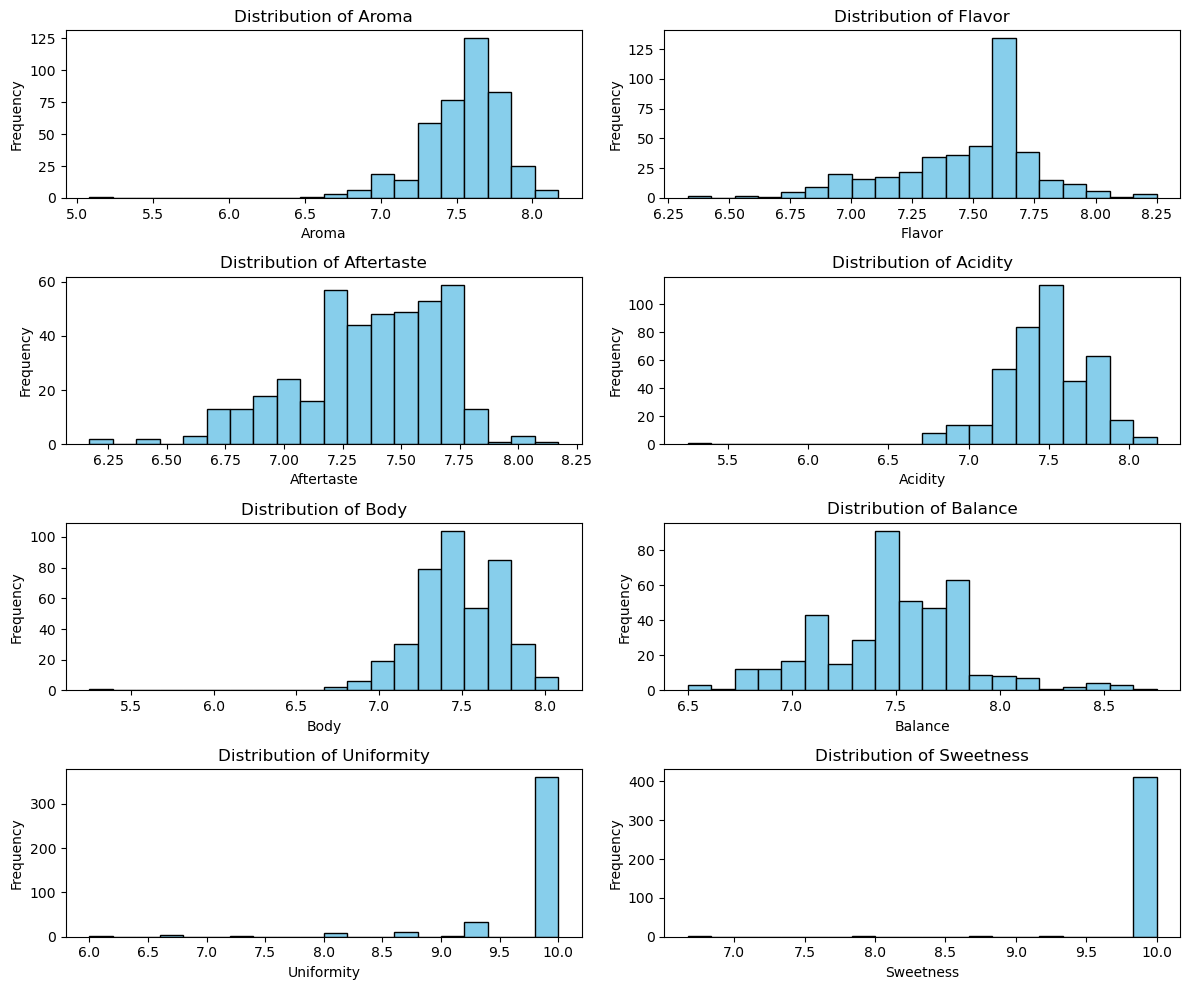

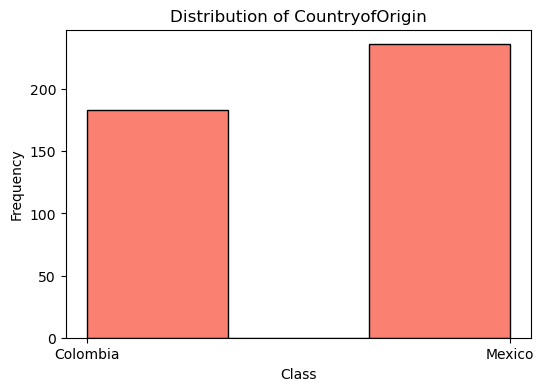

In [115]:
# Display the wine data
plt.figure(figsize=(12, 10))
for i, feature in enumerate(feature_names):
    plt.subplot(4, 2, i+1) 
    plt.hist(X[:, i], bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 4))
plt.hist(y, bins=3, color='salmon', edgecolor='black')
plt.title(f"Distribution of {target_name}")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks([0, 1], ["Colombia", "Mexico"])
plt.show()

In [116]:
#Splitting the data into test and (validation and training)
X_train_val, X_test, y_train_val, y_test = train_test_split(X,y, test_size=0.3, random_state=seed, shuffle=True)

# Use k fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

## Tuning and testing my decision tree on coffee data:

In [117]:
# Find best values for hyperparameters for my own decision tree classifier
best_hyperparameters_for_decisionTree = tune_decision_tree("DecisionTree", X_train_val, y_train_val, decision_tree_max_depth_params, criterion, max_features, kf)

print(best_hyperparameters_for_decisionTree)

print(f"The best average accuracy is {best_hyperparameters_for_decisionTree[0]} with Max_depth: {best_hyperparameters_for_decisionTree[1]}, Criterion: {best_hyperparameters_for_decisionTree[2]}, Max_features: {best_hyperparameters_for_decisionTree[3]}.\n")

[np.float64(0.7405026300409119), 3, 'gini', None]
The best average accuracy is 0.7405026300409119 with Max_depth: 3, Criterion: gini, Max_features: None.



In [118]:
# Testing my DecisionTree with the the hyperparameters

rf = DecisionTree(max_depth=best_hyperparameters_for_decisionTree[1], criterion=best_hyperparameters_for_decisionTree[2], max_features=best_hyperparameters_for_decisionTree[3], seed=seed)

rf.fit(X_train_val, y_train_val)

print(f"Training and validation accuracy: {accuracy_score(y_train_val, rf.predict(X_train_val))}")
print(f"Test accuracy: {accuracy_score(y_test, rf.predict(X_test))}")



Training and validation accuracy: 0.7713310580204779
Test accuracy: 0.746031746031746


## Tuning and testing my random forest on coffee data:

In [119]:
# Find best values for hyperparameters for my own random forest classifier

best_hypermeters_random_forest = tune_random_forest("RandomForest",X_train_val, y_train_val, n_estimators, max_depth_params, criterion, max_features, kf)


print(best_hypermeters_random_forest)

print(f"The best average accuracy is {best_hypermeters_random_forest[0]} with N_estimators: {best_hypermeters_random_forest[1]}, Max_depth: {best_hypermeters_random_forest[2]}, Criterion: {best_hypermeters_random_forest[3]}, Max_features: {best_hypermeters_random_forest[4]}.\n")


[np.float64(0.8572764465225013), 2, None, 'entropy', None]
The best average accuracy is 0.8572764465225013 with N_estimators: 2, Max_depth: None, Criterion: entropy, Max_features: None.



In [120]:
# Testing the hyperparameters on test set with my own random forest classifier

rf = RandomForest(n_estimators=best_hypermeters_random_forest[1], max_depth=best_hypermeters_random_forest[2], criterion=best_hypermeters_random_forest[3], max_features=best_hypermeters_random_forest[4], seed=seed)

rf.fit(X_train_val,y_train_val)

print(f"Training and validation accuracy: {accuracy_score(y_train_val, rf.predict(X_train_val))}")
print(f"Test accuracy: {accuracy_score(y_test, rf.predict(X_test))}")

Training and validation accuracy: 0.9078498293515358
Test accuracy: 0.7380952380952381
